In [104]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')
dir_path = "/content/drive/My Drive/CMPE257_PROJECT/"
NVDA_path ='NVDA_hist.xlsx'
NVDQ_path ='NVDQ_hist.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
file_path_nvda = dir_path  + NVDA_path
file_path_nvdaq = dir_path  + NVDQ_path

df_NVDA = pd.read_excel(file_path_nvda)
df_NVDAQ = pd.read_excel(file_path_nvdaq)


df_NVDA.index = pd.to_datetime(df_NVDA['Date'])
df_NVDAQ.index = pd.to_datetime(df_NVDAQ['Date'])

print(df_NVDA.head())
print(df_NVDAQ.head())

print("SHAPES")
print(df_NVDA.shape)
print(df_NVDAQ.shape)

                 Date    Open    High     Low   Close  Adj Close       Volume
Date                                                                         
2024-12-13 2024-12-13  138.94  139.60  132.54  134.25     134.25  230976400.0
2024-12-12 2024-12-12  137.08  138.44  135.80  137.34     137.34  159211400.0
2024-12-11 2024-12-11  137.36  140.17  135.21  139.31     139.31  184905200.0
2024-12-10 2024-12-10  139.01  141.82  133.79  135.07     135.07  210020900.0
2024-12-09 2024-12-09  138.97  139.95  137.13  138.81     138.81  189308600.0
                 Date  Open   High    Low  Close  Adj Close      Volume
Date                                                                   
2024-12-13 2024-12-13  3.29  3.620  3.260  3.530      3.530  65457800.0
2024-12-12 2024-12-12   3.4  3.450  3.325  3.380      3.380  39795900.0
2024-12-11 2024-12-11  3.38  3.500  3.240  3.280      3.280  62519900.0
2024-12-10 2024-12-10  3.32  3.564  3.180  3.500      3.500  57788000.0
2024-12-09 2024-12-09 

# Data Preprocessing / Splitting  

In [106]:
from sklearn.model_selection import train_test_split

# break down date column into month and day
df_NVDA['Month'] = df_NVDA['Date'].dt.month
df_NVDA['Day_month'] = df_NVDA['Date'].dt.day
df_NVDA["Day_week"] = df_NVDA['Date'].dt.dayofweek

df_NVDAQ['Month'] = df_NVDAQ['Date'].dt.month
df_NVDAQ['Day_month'] = df_NVDAQ['Date'].dt.day
df_NVDAQ["Day_week"] = df_NVDAQ['Date'].dt.dayofweek

# drop columns
df_NVDA.drop('Date',axis=1,inplace=True)
df_NVDAQ.drop('Date',axis=1,inplace=True)

# drop NaN (for stock splits and dividend)
df_NVDA.dropna(inplace=True)
df_NVDAQ.dropna(inplace=True)

# check column types
print(df_NVDA.dtypes)
print(df_NVDAQ.dtypes)

Open          object
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
Month          int32
Day_month      int32
Day_week       int32
dtype: object
Open          object
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
Month          int32
Day_month      int32
Day_week       int32
dtype: object


In [107]:
# change 'Open' type to float
df_NVDA["Open"]= df_NVDA["Open"].astype(float)
df_NVDAQ["Open"]= df_NVDAQ["Open"].astype(float)
df_NVDA.head()

,Open,High,Low,Close,Adj Close,Volume,Month,Day_month,Day_week
Date,,,,,,,,,
2024-12-13,138.94,139.60,132.54,134.25,134.25,230976400.0,12,13,4
2024-12-12,137.08,138.44,135.80,137.34,137.34,159211400.0,12,12,3
2024-12-11,137.36,140.17,135.21,139.31,139.31,184905200.0,12,11,2
2024-12-10,139.01,141.82,133.79,135.07,135.07,210020900.0,12,10,1
2024-12-09,138.97,139.95,137.13,138.81,138.81,189308600.0,12,9,0


In [108]:
# rearranging column orders
df_NVDA  = df_NVDA[['High','Low','Close','Adj Close','Volume','Month','Day_month','Day_week','Open']]
df_NVDAQ = df_NVDAQ[['High','Low','Close','Adj Close','Volume','Month','Day_month','Day_week','Open']]
df_NVDA.head()

,High,Low,Close,Adj Close,Volume,Month,Day_month,Day_week,Open
Date,,,,,,,,,
2024-12-13,139.60,132.54,134.25,134.25,230976400.0,12,13,4,138.94
2024-12-12,138.44,135.80,137.34,137.34,159211400.0,12,12,3,137.08
2024-12-11,140.17,135.21,139.31,139.31,184905200.0,12,11,2,137.36
2024-12-10,141.82,133.79,135.07,135.07,210020900.0,12,10,1,139.01
2024-12-09,139.95,137.13,138.81,138.81,189308600.0,12,9,0,138.97


## Targets are high, low, close

# Split Train and Test

## For NVDA

In [109]:
from sklearn.preprocessing import MinMaxScaler

slide = 5

def create_datasets(df_array,slide):
  X=[]
  y= []
  for i in range(len(df_array)-slide):
    X.append([r for r in df_array[i:i+slide]])
    y.append([df_array[i+slide][0],df_array[i+slide][1], df_array[i+slide][2]])
  X_array= np.array(X)
  y_array= np.array(y)
  return X_array, y_array


df_NVDA_array = df_NVDA.to_numpy()
df_NVDAQ_array = df_NVDAQ.to_numpy()

X_NVDA,y_NVDA =create_datasets(df_NVDA_array,slide)
X_NVDAQ,y_NVDAQ =create_datasets(df_NVDAQ_array,slide)


print("X NVDA SHAPE", X_NVDA.shape)
print("y NVDA SHAPE", y_NVDA.shape)
print()
print("X NVDAQ SHAPE", X_NVDAQ.shape)
print("X NVDAQ SHAPE", y_NVDAQ.shape)


# splitting into train and test
X_train_NVDA, X_test_NVDA, y_train_NVDA, y_test_NVDA = train_test_split(X_NVDA, y_NVDA, test_size=0.2, shuffle=False)
X_train_NVDAQ, X_test_NVDAQ, y_train_NVDAQ, y_test_NVDAQ = train_test_split(X_NVDAQ, y_NVDAQ, test_size=0.2, shuffle=False)

# Normalize
max_high_NVDA = X_train_NVDA[:,:,0].max()
min_high_NVDA = X_train_NVDA[:,:,0].min()

max_low_NVDA = X_train_NVDA[:,:,1].max()
min_low_NVDA = X_train_NVDA[:,:,1].min()

max_close_NVDA = X_train_NVDA[:,:,2].max()
min_close_NVDA = X_train_NVDA[:,:,2].min()

max_adj_close_NVDA = X_train_NVDA[:,:,3].max()
min_adj_close_NVDA = X_train_NVDA[:,:,3].min()

max_volume_NVDA = X_train_NVDA[:,:,4].max()
min_volume_NVDA = X_train_NVDA[:,:,4].min()

max_month_NVDA = X_train_NVDA[:,:,5].max()
min_month_NVDA = X_train_NVDA[:,:,5].min()

max_day_month_NVDA = X_train_NVDA[:,:,6].max()
min_day_month_NVDA = X_train_NVDA[:,:,6].min()

max_day_week_NVDA = X_train_NVDA[:,:,7].max()
min_day_week_NVDA = X_train_NVDA[:,:,7].min()

max_open_NVDA = X_train_NVDA[:,:,8].max()
min_open_NVDA = X_train_NVDA[:,:,8].min()


X_train_NVDA[:,:,0]=(X_train_NVDA[:,:,0] - min_high_NVDA)/(max_high_NVDA - min_high_NVDA)
X_train_NVDA[:,:,1]=(X_train_NVDA[:,:,1] - min_low_NVDA)/(max_low_NVDA - min_low_NVDA)
X_train_NVDA[:,:,2]=(X_train_NVDA[:,:,2] - min_close_NVDA)/(max_close_NVDA - min_close_NVDA)
X_train_NVDA[:,:,3]=(X_train_NVDA[:,:,3] - min_adj_close_NVDA)/(max_adj_close_NVDA - min_adj_close_NVDA)
X_train_NVDA[:,:,4]=(X_train_NVDA[:,:,4] - min_volume_NVDA)/(max_volume_NVDA - min_volume_NVDA)
X_train_NVDA[:,:,5]=(X_train_NVDA[:,:,5] - min_month_NVDA)/(max_month_NVDA - min_month_NVDA)
X_train_NVDA[:,:,6]=(X_train_NVDA[:,:,6] - min_day_month_NVDA)/(max_day_month_NVDA - min_day_month_NVDA)
X_train_NVDA[:,:,7]=(X_train_NVDA[:,:,7] - min_day_week_NVDA)/(max_day_week_NVDA - min_day_week_NVDA)
X_train_NVDA[:,:,8]=(X_train_NVDA[:,:,8] - min_open_NVDA)/(max_open_NVDA - min_open_NVDA)


X_test_NVDA[:,:,0]=(X_test_NVDA[:,:,0] - min_high_NVDA)/(max_high_NVDA - min_high_NVDA)
X_test_NVDA[:,:,1]=(X_test_NVDA[:,:,1] - min_low_NVDA)/(max_low_NVDA - min_low_NVDA)
X_test_NVDA[:,:,2]=(X_test_NVDA[:,:,2] - min_close_NVDA)/(max_close_NVDA - min_close_NVDA)
X_test_NVDA[:,:,2]=(X_test_NVDA[:,:,3] - min_adj_close_NVDA)/(max_adj_close_NVDA - min_adj_close_NVDA)
X_test_NVDA[:,:,4]=(X_test_NVDA[:,:,4] - min_volume_NVDA)/(max_volume_NVDA - min_volume_NVDA)
X_test_NVDA[:,:,5]=(X_test_NVDA[:,:,5] - min_month_NVDA)/(max_month_NVDA - min_month_NVDA)
X_test_NVDA[:,:,6]=(X_test_NVDA[:,:,6] - min_day_month_NVDA)/(max_day_month_NVDA - min_day_month_NVDA)
X_test_NVDA[:,:,7]=(X_test_NVDA[:,:,7] - min_day_week_NVDA)/(max_day_week_NVDA - min_day_week_NVDA)
X_test_NVDA[:,:,8]=(X_test_NVDA[:,:,8] - min_open_NVDA)/(max_open_NVDA - min_open_NVDA)

y_train_NVDA[:,0]=(y_train_NVDA[:,0]- min_high_NVDA)/(max_high_NVDA - min_high_NVDA)
y_train_NVDA[:,1]=(y_train_NVDA[:,1]- min_low_NVDA)/(max_low_NVDA - min_low_NVDA)

y_test_NVDA[:,0]=(y_test_NVDA[:,0]- min_high_NVDA)/(max_high_NVDA - min_high_NVDA)
y_test_NVDA[:,1]=(y_test_NVDA[:,1]- min_low_NVDA)/(max_low_NVDA - min_low_NVDA)








max_high_NVDAQ = X_train_NVDAQ[:,:,0].max()
min_high_NVDAQ = X_train_NVDAQ[:,:,0].min()

max_low_NVDAQ = X_train_NVDAQ[:,:,1].max()
min_low_NVDAQ = X_train_NVDAQ[:,:,1].min()

max_close_NVDAQ = X_train_NVDAQ[:,:,2].max()
min_close_NVDAQ = X_train_NVDAQ[:,:,2].min()

max_adj_close_NVDAQ = X_train_NVDAQ[:,:,3].max()
min_adj_close_NVDAQ = X_train_NVDAQ[:,:,3].min()

max_volume_NVDAQ = X_train_NVDAQ[:,:,4].max()
min_volume_NVDAQ = X_train_NVDAQ[:,:,4].min()

max_month_NVDAQ = X_train_NVDAQ[:,:,5].max()
min_month_NVDAQ = X_train_NVDAQ[:,:,5].min()

max_day_month_NVDAQ = X_train_NVDAQ[:,:,6].max()
min_day_month_NVDAQ = X_train_NVDAQ[:,:,6].min()

max_day_week_NVDAQ = X_train_NVDAQ[:,:,7].max()
min_day_week_NVDAQ = X_train_NVDAQ[:,:,7].min()

max_open_NVDAQ = X_train_NVDAQ[:,:,8].max()
min_open_NVDAQ = X_train_NVDAQ[:,:,8].min()


X_train_NVDAQ[:,:,0]=(X_train_NVDAQ[:,:,0] - min_high_NVDAQ)/(max_high_NVDAQ - min_high_NVDAQ)
X_train_NVDAQ[:,:,1]=(X_train_NVDAQ[:,:,1] - min_low_NVDAQ)/(max_low_NVDAQ - min_low_NVDAQ)
X_train_NVDAQ[:,:,2]=(X_train_NVDAQ[:,:,2] - min_close_NVDAQ)/(max_close_NVDAQ - min_close_NVDAQ)
X_train_NVDAQ[:,:,3]=(X_train_NVDAQ[:,:,3] - min_adj_close_NVDAQ)/(max_adj_close_NVDAQ - min_adj_close_NVDAQ)
X_train_NVDAQ[:,:,4]=(X_train_NVDAQ[:,:,4] - min_volume_NVDAQ)/(max_volume_NVDAQ - min_volume_NVDAQ)
X_train_NVDAQ[:,:,5]=(X_train_NVDAQ[:,:,5] - min_month_NVDAQ)/(max_month_NVDAQ - min_month_NVDAQ)
X_train_NVDAQ[:,:,6]=(X_train_NVDAQ[:,:,6] - min_day_month_NVDAQ)/(max_day_month_NVDAQ - min_day_month_NVDAQ)
X_train_NVDAQ[:,:,7]=(X_train_NVDAQ[:,:,7] - min_day_week_NVDAQ)/(max_day_week_NVDAQ - min_day_week_NVDAQ)
X_train_NVDAQ[:,:,8]=(X_train_NVDAQ[:,:,8] - min_open_NVDAQ)/(max_open_NVDAQ - min_open_NVDAQ)


X_test_NVDAQ[:,:,0]=(X_test_NVDAQ[:,:,0] - min_high_NVDAQ)/(max_high_NVDAQ - min_high_NVDAQ)
X_test_NVDAQ[:,:,1]=(X_test_NVDAQ[:,:,1] - min_low_NVDAQ)/(max_low_NVDAQ - min_low_NVDAQ)
X_test_NVDAQ[:,:,2]=(X_test_NVDAQ[:,:,2] - min_close_NVDAQ)/(max_close_NVDAQ - min_close_NVDAQ)
X_test_NVDAQ[:,:,2]=(X_test_NVDAQ[:,:,3] - min_adj_close_NVDAQ)/(max_adj_close_NVDAQ - min_adj_close_NVDAQ)
X_test_NVDAQ[:,:,4]=(X_test_NVDAQ[:,:,4] - min_volume_NVDAQ)/(max_volume_NVDAQ - min_volume_NVDAQ)
X_test_NVDAQ[:,:,5]=(X_test_NVDAQ[:,:,5] - min_month_NVDAQ)/(max_month_NVDAQ - min_month_NVDAQ)
X_test_NVDAQ[:,:,6]=(X_test_NVDAQ[:,:,6] - min_day_month_NVDAQ)/(max_day_month_NVDAQ - min_day_month_NVDAQ)
X_test_NVDAQ[:,:,7]=(X_test_NVDAQ[:,:,7] - min_day_week_NVDAQ)/(max_day_week_NVDAQ - min_day_week_NVDAQ)
X_test_NVDAQ[:,:,8]=(X_test_NVDAQ[:,:,8] - min_open_NVDAQ)/(max_open_NVDAQ - min_open_NVDAQ)

y_train_NVDAQ[:,0]=(y_train_NVDAQ[:,0]- min_high_NVDAQ)/(max_high_NVDAQ - min_high_NVDAQ)
y_train_NVDAQ[:,1]=(y_train_NVDAQ[:,1]- min_low_NVDAQ)/(max_low_NVDAQ - min_low_NVDAQ)

y_test_NVDAQ[:,0]=(y_test_NVDAQ[:,0]- min_high_NVDAQ)/(max_high_NVDAQ - min_high_NVDAQ)
y_test_NVDAQ[:,1]=(y_test_NVDAQ[:,1]- min_low_NVDAQ)/(max_low_NVDAQ - min_low_NVDAQ)




print()
print("X_train NVDA SHAPE ",X_train_NVDA.shape)
print("y_train NVDA SHAPE ",y_train_NVDA.shape)
print("X_test NVDAQ SHAPE ",X_test_NVDAQ.shape)
print("y_test NVDAQ SHAPE ",y_test_NVDAQ.shape)

X NVDA SHAPE (285, 5, 9)
y NVDA SHAPE (285, 3)

X NVDAQ SHAPE (285, 5, 9)
X NVDAQ SHAPE (285, 3)

X_train NVDA SHAPE  (228, 5, 9)
y_train NVDA SHAPE  (228, 3)
X_test NVDAQ SHAPE  (57, 5, 9)
y_test NVDAQ SHAPE  (57, 3)


# Split

In [110]:
# 3 targets for NVDA = high , low , close
# first starting by finding weights for 'high' target

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4169.7178 - mae: 36.6858
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4001.4873 - mae: 35.7506  
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3902.3923 - mae: 35.3097 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3480.7578 - mae: 33.6531  
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1979.8792 - mae: 27.5716  
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 740.8278 - mae: 19.1607  
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 488.3739 - mae: 13.4320  
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 320.2342 - mae: 9.7652  
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 290.1844 - mae: 8.9652 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 236.3252 - mae: 8.2283 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 182.7901 - mae: 7.4710  
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 133.1458 - mae: 6.0987 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━

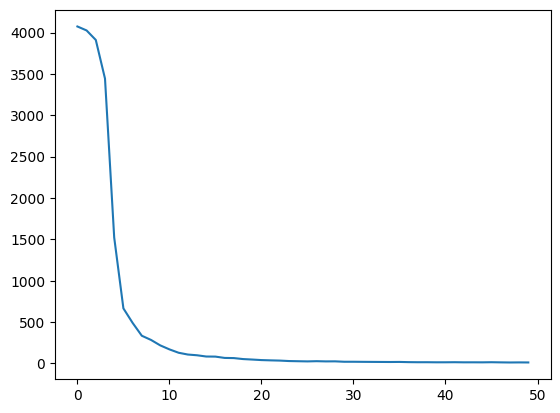

In [114]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

input = 5
features = 9

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (input,features)))
model.add(Dense(3))
model.compile(optimizer='adam',loss='mse', metrics=['mae'])
model.fit(X_train_NVDA, y_train_NVDA , epochs=50)
loss= model.history.history['loss']
plt.plot(loss)
